In [13]:
import os
import gc
import pandas as pd
from tqdm.notebook import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt
import re

In [2]:
path_news = './stock-news/'
list_file_news = [os.path.join(path_news, filename) for filename in os.listdir(path_news) if os.path.isfile(os.path.join(path_news, filename))]

In [3]:
lm_negative = pd.read_csv('lm_negative.csv', header=None)[0].tolist()
lm_negative = {word.lower() : -1 for word in lm_negative}

lm_positive = pd.read_csv('lm_positive.csv', header=None)[0].tolist()
lm_positive = {word.lower() : 1 for word in lm_positive}

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
              "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
              "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
              "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
              "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
              "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]
    
    if word.lower() in negate:
        return True
    else:
        return False

def lm_analysis(text):
    pos_count = 0
    neg_count = 0
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())
    word_count = len(input_words)

    for i in range(0, word_count):
        if input_words[i] in lm_negative:
            neg_count += 1

        if input_words[i] in lm_positive:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                else:
                    pos_count += 1
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                else:
                    pos_count += 1
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                else:
                    pos_count += 1
            elif i == 0:
                pos_count += 1
    
    if pos_count + neg_count > 0:
        polarity = (pos_count - neg_count) / (pos_count + neg_count)
    else:
        polarity = 0
    
    subjectivity = (pos_count + neg_count) / word_count if word_count > 0 else 0
    pos_rate = pos_count / word_count if word_count > 0 else 0
    neg_rate = neg_count / word_count if word_count > 0 else 0
    
    return {'Positive' : pos_rate, 
            'Negative' : neg_rate, 
            'Polarity' : polarity, 
            'Subjectivity' : subjectivity}

def lm_sentiment_article(list_word):
#     list_word = text.replace('\t', ' ').replace('\n', ' ').split(' ')
    df_list_word = pd.DataFrame(list_word, columns=['words'])
    df_list_word['lm_analysis'] = df_list_word['words'].apply(lm_analysis)
    df_list_word['pos'] = df_list_word['lm_analysis'].apply(lambda x: x['Positive'])
    df_list_word['neg'] = df_list_word['lm_analysis'].apply(lambda x: x['Negative'])
    sum_diff = (df_list_word['pos'] - df_list_word['neg']).sum()
    if sum_diff < 0:
        return -1
    if sum_diff > 0:
        return 1
    return 0

def vader_sentiment_article(list_word):
#     list_word = text.replace('\t', ' ').replace('\n', ' ').split(' ')
    df_list_word = pd.DataFrame(list_word, columns=['words'])
    
    analyzer = SentimentIntensityAnalyzer()
    df_list_word['vader_analysis'] = df_list_word['words'].apply(analyzer.polarity_scores)
    df_list_word['pos'] = df_list_word['vader_analysis'].apply(lambda x: x['pos'])
    df_list_word['neg'] = df_list_word['vader_analysis'].apply(lambda x: x['neg'])
    
    sum_diff = (df_list_word['pos'] - df_list_word['neg']).sum()
    if sum_diff < 0:
        return -1
    if sum_diff > 0:
        return 1
    return 0

In [4]:
article = '''Patent infringement pursued against same companies in U.S. District Court. Test "wasn't good".
SUNNYVALE, Calif.--(BUSINESS WIRE)--December 02, 2010--
Rambus Inc. (Nasdaq:RMBS), one of the world's premier technology licensing companies, today announced it has filed a complaint with the United States International Trade Commission (ITC) requesting the commencement of an investigation pertaining to products from Broadcom Corporation, Freescale Semiconductor, Inc., LSI Corporation, MediaTek Inc., NVIDIA Corporation and STMicroelectronics N. V. The complaint seeks an exclusion order barring the importation, sale for importation, or sale after importation of products from Broadcom, Freescale, LSI, NVIDIA and STMicroelectronics that infringe certain patents from the Dally1 family of patents, and of products from Broadcom, Freescale, LSI, MediaTek and STMicroelectronics that infringe certain patents from the Barth family of patents. In an earlier investigation requested by Rambus the ITC found that these same Barth patents were valid and infringed by NVIDIA products, and issued an exclusion order in July of this year.
"We have been attempting to license these companies for some time to no avail. One of the respondents frankly told us that the only way they would get serious is if we sued them. Others pursued a strategy of delay rather than negotiate a reasonable resolution," said Harold Hughes, president and chief executive officer at Rambus. "Rambus has invested hundreds of millions of dollars developing a portfolio of technologies that are foundational for many digital electronics. There is widespread knowledge within the industry about our patents including their use in standards-compatible products accused in these actions. In fairness to our shareholders and to our paying licensees, we take these steps to protect our patented innovations and pursue fair compensation for their use."
For the Dally patents, the accused semiconductor products from these companies include ones that incorporate PCI Express, certain Serial ATA, certain Serial Attached SCSI (SAS), and DisplayPort interfaces. In the case of the Barth patents, the accused semiconductor products include ones that incorporate DDR, DDR2, DDR3, mobile DDR, LPDDR, LPDDR2, and GDDR3 memory controllers. Accused semiconductor products in the complaint include graphics processors, media processors, communications processors, chip sets and other logic integrated circuits (ICs).
In addition to Broadcom, Freescale, LSI, MediaTek, NVIDIA and STMicroelectronics, the ITC complaint names companies whose products incorporate the accused semiconductor products and are imported, sold for importation, or sold after importation into the United States. These products include personal computers, workstations, servers, routers, mobile phones and other handheld devices, set-top boxes, Blu-ray players motherboards, plug-in cards, hard drives and modems. The ITC is expected to decide whether to initiate an investigation under this complaint within 30-45 days.
Rambus today also filed separate actions for patent infringement against Broadcom, Freescale, LSI, MediaTek and STMicroelectronics in the United States District Court for the Northern District of California. The lawsuits allege that semiconductor products with certain memory controllers and/or serial links from the above companies infringe certain patents from the Farmwald-Horowitz, Barth, and Dally patent families. In the case of MediaTek, only infringement of the Barth and Farmwald-Horowitz patents for certain memory controllers is alleged. Rambus also filed an action in the United States District Court for the Northern District of California against NVIDIA for infringement of certain Dally patents. The categories of accused semiconductor products in the District Court complaints include the same categories accused in the ITC complaint, as well as SDR memory controllers. Rambus is seeking injunctive relief barring the infringement, contributory infringement, and inducement to infringe the patents, as well as monetary damages.
Rambus management will discuss the filing of these actions during a special conference call today at 5:00 p.m. PT. The call will be webcast and can be accessed through the Rambus website. A replay will be available following the call on Rambus' Investor Relations website or for one week at the following numbers: (800) 642-1687 (domestic) or (706) 645-9291 (international) with ID# 29122159. Further information regarding these legal actions will be made available at http://investor.rambus.com in the Litigation Update section.
1 Rambus is the exclusive licensee for the Dally family of patents which are owned by Massachusetts Institute of Technology. This license was assigned to Rambus as a part of its 2003 acquisition of technology and IP from Velio Communications, a company founded by Dr. William Dally.
'''
list_word = article.replace('\t', ' ').replace('\n', ' ').split(' ')
df_list_word = pd.DataFrame(list_word, columns=['words'])

analyzer = SentimentIntensityAnalyzer()
df_list_word['vader_analysis'] = df_list_word['words'].apply(analyzer.polarity_scores)
df_list_word['pos'] = df_list_word['vader_analysis'].apply(lambda x: x['pos'])
df_list_word['neg'] = df_list_word['vader_analysis'].apply(lambda x: x['neg'])
df_list_word

,words,vader_analysis,pos,neg
0,Patent,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0
1,infringement,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0,1.0
2,pursued,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0
3,against,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0
4,same,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0
...,...,...,...,...
701,by,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0
702,Dr.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0
703,William,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0
704,Dally.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,0.0


In [5]:
def make_sentiment_features(df):
    print(df.shape)
    df['article_concat_split'] = df['article_concat'].apply(lambda x: x.replace('\t', ' ').replace('\n', ' ').split(' '))
    df['vader_sentiment'] = df['article_concat_split'].apply(vader_sentiment_article)
    df['vader_sentiment_pos'] = (df['vader_sentiment'] > 0).astype('int')
    df['vader_sentiment_neg'] = (df['vader_sentiment'] < 0).astype('int')
    
    df['lm_sentiment'] = df['article_concat_split'].apply(lm_sentiment_article)
    df['lm_sentiment_pos'] = (df['lm_sentiment'] > 0).astype('int')
    df['lm_sentiment_neg'] = (df['lm_sentiment'] < 0).astype('int')
    
#     df['stock_news_vader_neg'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['neg'], axis=1)
#     df['stock_news_vader_pos'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['pos'], axis=1)
#     df['stock_news_vader_neu'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['neu'], axis=1)
#     df['stock_news_vader_compound'] = df.apply(lambda x: analyzer.polarity_scores(x['article_concat'])['compound'], axis=1)
    
#     df['stock_news_wordnet_pos'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[0], axis=1)
#     df['stock_news_wordnet_neg'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[1], axis=1)
#     df['stock_news_wordnet_obj'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[2], axis=1)
#     df['stock_news_wordnet_total'] = df.apply(lambda x: sentiwordnet_analysis(x['article_concat_pos_tag'])[3], axis=1)
    
#     df['stock_news_lm_dict'] = df.apply(lambda x: lm_analysis(x['article_concat']), axis=1)
#     df['stock_news_lm_pos'] = df.apply(lambda x: x['stock_news_lm_dict']['Positive'], axis=1)
#     df['stock_news_lm_neg'] = df.apply(lambda x: x['stock_news_lm_dict']['Negative'], axis=1)
#     df['stock_news_lm_polar'] = df.apply(lambda x: x['stock_news_lm_dict']['Polarity'], axis=1)
#     df['stock_news_lm_subject'] = df.apply(lambda x: x['stock_news_lm_dict']['Subjectivity'], axis=1)
    
#     df.drop('stock_news_lm_dict', axis=1, inplace=True)
    return df

In [6]:
def daily_sentiment_score(pos_num, neg_num):
    if pos_num > neg_num:
        return 2 * pos_num / (pos_num + neg_num) - 1
    
    if pos_num < neg_num:
        return 1 - 2  * neg_num / (pos_num + neg_num)

    return 0

In [7]:
df = None
filter_start_time = '2009-10-01'

for file in tqdm(list_file_news):
    basename = os.path.basename(file)
    os.path.splitext(basename)
    file_name, file_extension = os.path.splitext(basename)
    if file_extension != '.csv':
        continue
        
    df_news = pd.read_csv(file)[['time', 'title_name', 'para']]
    
    df_news.loc[df_news['time'].str.contains('ago'), 'time'] = 'Aug 06, 2021'
    df_news['Date'] = pd.to_datetime(df_news['time'])
    df_news = df_news[df_news['Date'] >= filter_start_time]
    df_news.drop_duplicates(subset=['title_name'], keep='first', inplace=True)
    df_news.drop('time', axis=1, inplace=True)
    df_news['symbol'] = file_name
    df_news.rename(columns={'title_name' : 'article_title'}, inplace=True)
    df_news.rename(columns={'para' : 'article_abstract'}, inplace=True)
    df_news = df_news[['symbol', 'Date', 'article_title', 'article_abstract']]
    
    df_news[['article_title', 'article_abstract']] = df_news[['article_title', 'article_abstract']].fillna('')
    df_news['article_concat'] = df_news['article_title'] + ' ' + df_news['article_abstract']
    
    df_news = make_sentiment_features(df_news)
    
    if df is None:
        df = df_news.copy()
    else:
        df = pd.concat([df, df_news], axis=0)
    
    del df_news
    gc.collect()
#     break

  0%|          | 0/498 [00:00<?, ?it/s]

(61, 5)
(1493, 5)
(128, 5)
(13111, 5)
(478, 5)
(220, 5)
(72, 5)
(322, 5)
(335, 5)
(432, 5)
(139, 5)
(185, 5)
(263, 5)
(162, 5)
(31, 5)
(74, 5)
(74, 5)
(64, 5)
(508, 5)
(44, 5)
(53, 5)
(140, 5)
(139, 5)
(107, 5)
(173, 5)
(112, 5)
(35, 5)
(336, 5)
(21, 5)
(1091, 5)
(28, 5)
(483, 5)
(105, 5)
(114, 5)
(11509, 5)
(55, 5)
(30, 5)
(342, 5)
(178, 5)
(437, 5)
(82, 5)
(45, 5)
(156, 5)
(42, 5)
(20, 5)
(403, 5)
(67, 5)
(654, 5)
(39, 5)
(24, 5)
(987, 5)
(124, 5)
(6996, 5)
(6248, 5)
(112, 5)
(415, 5)
(578, 5)
(103, 5)
(94, 5)
(665, 5)
(16, 5)
(237, 5)
(911, 5)
(1949, 5)
(140, 5)
(547, 5)
(29, 5)
(158, 5)
(114, 5)
(55, 5)
(5300, 5)
(184, 5)
(22, 5)
(1627, 5)
(227, 5)
(151, 5)
(74, 5)
(68, 5)
(352, 5)
(62, 5)
(22, 5)
(57, 5)
(67, 5)
(109, 5)
(84, 5)
(44, 5)
(38, 5)
(317, 5)
(377, 5)
(35, 5)
(152, 5)
(159, 5)
(107, 5)
(1432, 5)
(1010, 5)
(670, 5)
(180, 5)
(47, 5)
(182, 5)
(52, 5)
(314, 5)
(129, 5)
(103, 5)
(537, 5)
(593, 5)
(268, 5)
(22, 5)
(29, 5)
(712, 5)
(1197, 5)
(288, 5)
(61, 5)
(63, 5)
(117, 5)
(

In [8]:
df.head()

,symbol,Date,article_title,article_abstract,article_concat,article_concat_split,vader_sentiment,vader_sentiment_pos,vader_sentiment_neg,lm_sentiment,lm_sentiment_pos,lm_sentiment_neg
0,A,2021-07-29,Will Agilent Technologies Continue to Surge Hi...,Agilent (A) has generated significant returns ...,Will Agilent Technologies Continue to Surge Hi...,"[Will, Agilent, Technologies, Continue, to, Su...",1,1,0,0,0,0
1,A,2021-07-13,3 Large-Cap Stocks to Buy for the Long Term,Because the stock market is expected to remain...,3 Large-Cap Stocks to Buy for the Long Term Be...,"[3, Large-Cap, Stocks, to, Buy, for, the, Long...",-1,0,1,-1,0,1
2,A,2021-07-12,KeyBanc Stick to Their Buy Rating for Agilent,KeyBanc analyst Paul Knight maintained a Buy r...,KeyBanc Stick to Their Buy Rating for Agilent ...,"[KeyBanc, Stick, to, Their, Buy, Rating, for, ...",1,1,0,-1,0,1
3,A,2021-06-25,2 Healthcare Stocks That Could Grow Your Portf...,The healthcare industry has attracted much att...,2 Healthcare Stocks That Could Grow Your Portf...,"[2, Healthcare, Stocks, That, Could, Grow, You...",0,0,0,-1,0,1
4,A,2021-06-04,3 Must-Own Healthcare Stocks for June,Despite the healthcare system’s limitations ha...,3 Must-Own Healthcare Stocks for June Despite ...,"[3, Must-Own, Healthcare, Stocks, for, June, D...",1,1,0,-1,0,1


In [10]:
df[['symbol', 'Date', 'vader_sentiment', 'vader_sentiment_pos', 'vader_sentiment_neg', 
    'lm_sentiment', 'lm_sentiment_pos', 'lm_sentiment_neg']] \
    .to_csv('./exported_data/news_sentiment_analysis/us_stock_news_sentiment_analysis_rawdata.csv', index=False)

In [14]:
df_us = pd.read_csv('./exported_data/news_sentiment_analysis/us_stock_news_sentiment_analysis_rawdata.csv')
df_au = pd.read_csv('./exported_data/news_sentiment_analysis/au_stock_news_sentiment_analysis_rawdata.csv')
df_vn = pd.read_csv('./exported_data/news_sentiment_analysis/vn_stock_news_sentiment_analysis_rawdata.csv')

In [16]:
df_us = df_us[['vader_sentiment', 'vader_sentiment_pos', 'vader_sentiment_neg', 'lm_sentiment', 'lm_sentiment_pos', 'lm_sentiment_neg']]
df_vn = df_vn[['vader_sentiment', 'vader_sentiment_pos', 'vader_sentiment_neg', 'lm_sentiment', 'lm_sentiment_pos', 'lm_sentiment_neg']]
df_au = df_au[['vader_sentiment', 'vader_sentiment_pos', 'vader_sentiment_neg', 'lm_sentiment', 'lm_sentiment_pos', 'lm_sentiment_neg']]

In [23]:
df = df_us.append(df_au, ignore_index=True).append(df_vn, ignore_index=True).reset_index(drop=True)
df.head()

,vader_sentiment,vader_sentiment_pos,vader_sentiment_neg,lm_sentiment,lm_sentiment_pos,lm_sentiment_neg
0,1,1,0,0,0,0
1,-1,0,1,-1,0,1
2,1,1,0,-1,0,1
3,0,0,0,-1,0,1
4,1,1,0,-1,0,1


In [17]:
pd.merge([df_us, df_au, df_vn])

TypeError: merge() got an unexpected keyword argument 'axis'

In [26]:
df.describe()

,vader_sentiment,vader_sentiment_pos,vader_sentiment_neg,lm_sentiment,lm_sentiment_pos,lm_sentiment_neg
count,356692.000000,356692.00000,356692.000000,356692.000000,356692.000000,356692.000000
mean,0.260281,0.51450,0.254219,-0.533342,0.005279,0.538622
std,0.837243,0.49979,0.435422,0.509360,0.072465,0.498507
min,-1.000000,0.00000,0.000000,-1.000000,0.000000,0.000000
25%,-1.000000,0.00000,0.000000,-1.000000,0.000000,0.000000
50%,1.000000,1.00000,0.000000,-1.000000,0.000000,1.000000
75%,1.000000,1.00000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [24]:
df[['vader_sentiment', 'vader_sentiment_pos', 'vader_sentiment_neg', 
    'lm_sentiment', 'lm_sentiment_pos', 'lm_sentiment_neg']].sum(axis=0)

vader_sentiment         92840
vader_sentiment_pos    183518
vader_sentiment_neg     90678
lm_sentiment          -190239
lm_sentiment_pos         1883
lm_sentiment_neg       192122
dtype: int64

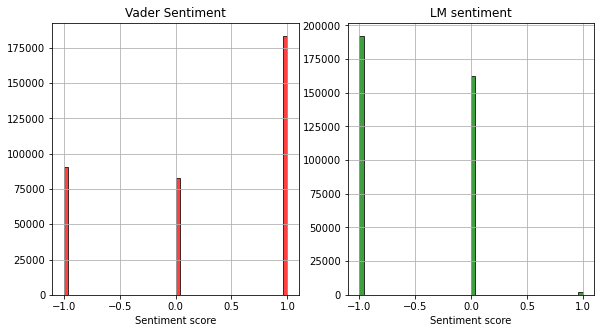

In [25]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.hist(df['vader_sentiment'], 
         50, 
         color = 'r', 
         edgecolor = 'black',
         alpha=0.75,)
plt.xlabel('Sentiment score')
plt.title('Vader Sentiment')
plt.grid(True)
plt.subplot(132)
plt.hist(df['lm_sentiment'], 
         50, 
         color='g',
         edgecolor = 'black', 
         alpha=0.75,)
plt.xlabel('Sentiment score')
plt.title('LM sentiment')
# plt.grid(True)
# plt.subplot(133)
# plt.hist(pd.concat([data.compound,data.s_compound]), 
#          50, 
#          color='g',
#          edgecolor = 'black', 
#          alpha=0.75)
# plt.xlabel('Compound Score')
# plt.title('Political News and Stock News')
plt.grid(True)
plt.show()

In [25]:
df_sentiment = df.groupby(['symbol', 'Date']) \
    .agg(lm_sentiment_pos=('lm_sentiment_pos', 'sum'), 
         lm_sentiment_neg=('lm_sentiment_neg', 'sum'),
         vader_sentiment_pos=('vader_sentiment_pos', 'sum'), 
         vader_sentiment_neg=('vader_sentiment_neg', 'sum'),) \
    .reset_index()

df_sentiment['daily_sentiment_score_lm'] = df_sentiment \
    .apply(lambda x: daily_sentiment_score(x['lm_sentiment_pos'], x['lm_sentiment_neg']), axis=1)
df_sentiment['daily_sentiment_score_vader'] = df_sentiment \
    .apply(lambda x: daily_sentiment_score(x['vader_sentiment_pos'], x['vader_sentiment_neg']), axis=1)

df_sentiment[['symbol', 'Date', 'daily_sentiment_score_lm', 'daily_sentiment_score_vader']].head()

,symbol,Date,daily_sentiment_score_lm,daily_sentiment_score_vader
0,A,2015-11-16,-1.0,1.0
1,A,2016-07-28,-1.0,0.0
2,A,2016-08-01,-1.0,1.0
3,A,2016-08-18,0.0,1.0
4,A,2016-11-15,0.0,0.0


In [26]:
df_sentiment.shape

(122636, 8)

In [28]:
df_sentiment.head()

,symbol,Date,lm_sentiment_pos,lm_sentiment_neg,vader_sentiment_pos,vader_sentiment_neg,daily_sentiment_score_lm,daily_sentiment_score_vader
0,A,2015-11-16,0,1,1,0,-1.0,1.0
1,A,2016-07-28,0,1,0,0,-1.0,0.0
2,A,2016-08-01,0,1,1,0,-1.0,1.0
3,A,2016-08-18,0,0,1,0,0.0,1.0
4,A,2016-11-15,0,0,0,0,0.0,0.0


In [29]:
df_sentiment[['symbol', 'Date', 'daily_sentiment_score_lm', 'daily_sentiment_score_vader']] \
    .to_csv('./exported_data/news_sentiment_analysis/us_stock_news_sentiment_analysis.csv', index=False)